In [36]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib3/")
sys.path.append("C:/dev/pycmqlib3/misc_scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
%matplotlib inline

In [37]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu'] #, 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd']#, 'AP', 'sp']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [38]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2015,5,1)
end_date = datetime.date(2020,7,14)

sim_products = ['rb', 'hc', 'i', 'j', 'jm'] #['IF', 'IH', 'IC']#['cu', 'al', 'zn', 'pb', 'ni', 'sn'] # [] # 
need_shift = 1
freq = 'm'

args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift}
ni_args = {'n': 1, 'roll_rule': '-40b', 'freq': freq, 'need_shift': need_shift}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift}
bond_args = {'n': 1, 'roll_rule': '-20b', 'freq': freq, 'need_shift': need_shift}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift}

df_list = []
for idx, asset in enumerate(sim_products):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in ['ni']:
        use_args = ni_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(backtest.sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    xdf = df[field_list]
    xdf.columns = [(asset, col) for col in xdf.columns]
    df_list.append(xdf)

all_df = pd.concat(df_list, axis = 1, sort = False).dropna().sort_values(\
                by=['date', 'min_id'])
print(all_df)

loading mkt = rb, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2015, 5, 1), 'end_date': datetime.date(2020, 7, 14)}
loading mkt = hc, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2015, 5, 1), 'end_date': datetime.date(2020, 7, 14)}
loading mkt = i, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2015, 5, 1), 'end_date': datetime.date(2020, 7, 14)}
loading mkt = j, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2015, 5, 1), 'end_date': datetime.date(2020, 7, 14)}
loading mkt = jm, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 1, 'start_date': datetime.date(2015, 5, 1), 'end_date': datetime.date(2020, 7, 14)}
                           date  min_id  (rb, open)  (rb, high)  (rb, low)  \
datetime                                                                     
2015-05-04 09:00

In [47]:
product_list = ['rb', 'i', 'j'] #
prod_fields = ['date', 'min_id'] + [(asset, field) for field in field_list for asset in product_list]
df = all_df[prod_fields].copy()

bar_freq = '14m'

split_dict = {'s1': [300, 2100],
             's2': [300, 1500, 2100],
             's3': [300, 1500, 1930, 2100],
             's4': [300, 1500, 1630, 1930, 2100],}
if 's' in bar_freq:
    xdf = df.copy()
    xdf = dh.day_split1(xdf, split_dict[bar_freq])
else:
    xdf = df.copy()
    xdf = dh.conv_ohlc_freq1(df, bar_freq) 
#xdf = df.copy()
#xdf = dh.day_split1(xdf, [300, 352, 450, 1500, 1528, 1630, 1655, 1724, 1930, 1949, 2018, 2047, 2100])

#xdf = dh.day_split1(xdf, [300, 1500, 1930, 2115])
xdf['start_min'] = xdf.index.to_series().apply(lambda x: misc.get_min_id(x))

win_list = [30]
ma_win = 12
std_win = 180
pos_std = 1
for asset in product_list:
    if need_shift == 1:
        xdf[(asset, 'lr')] = ((xdf[(asset, 'close')]- xdf[(asset, 'shift')]).astype('float')\
                                /(xdf[(asset, 'close')].shift(1) - xdf[(asset, 'shift')]) - 1.0) * 100.0
    else:
        xdf[(asset, 'lr')] = (xdf[(asset, 'close')].astype('float')\
                              / xdf[(asset, 'close')].shift(1) - 1.0) * 100.0
    for ix, win in enumerate(win_list):
        xdf[(asset, 'lr%s' % (ix))] = xdf[(asset, 'lr')].rolling(win).sum().rolling(ma_win).mean()
    if need_shift == 1:
        orig_close = xdf[(asset, 'close')] - xdf[(asset, 'shift')]
    elif need_shift == 2:
        orig_close = xdf[(asset, 'close')] * np.exp(-xdf[(asset, 'shift')])
    else:
        orig_close = xdf[(asset, 'close')]
    if pos_std == 0:
        xdf[(asset, 'std')] = orig_close
    elif pos_std == 1:
        xdf[(asset, 'std')] = xdf[(asset, 'lr')].rolling(std_win).std() * orig_close * 10.0
    elif pos_std == 2:
        xdf[(asset, 'std')] = xdf[(asset, 'close')].diff().rolling(std_win).std() * 10.0
#xdf[[(asset, 'open') for asset in product_list]].to_csv('data_dump_.csv')
adf_dict = {}
rank_dict = {}
rng_dict = {}
for col in ['lr%s' % (idx) for idx in range(len(win_list))]:
    adf_dict[col] = xdf[[(asset, col) for asset in product_list]]
    rank_dict[col] = adf_dict[col].rank(axis=1)
    rng_dict[col] = adf_dict[col].max(axis=1) - adf_dict[col].min(axis=1)
#xdf[[(asset, 'lr') for asset in product_list]].plot()

2 2
                      rb    i    j
datetime                          
2015-05-04 09:00:00  NaN  NaN  NaN
2015-05-04 09:10:00  NaN  NaN  NaN
2015-05-04 09:24:00  NaN  NaN  NaN
2015-05-04 09:38:00  NaN  NaN  NaN
2015-05-04 09:52:00  NaN  NaN  NaN
...                  ...  ...  ...
2020-07-14 13:50:00  2.0  3.0  1.0
2020-07-14 14:04:00  2.0  3.0  1.0
2020-07-14 14:18:00  2.0  3.0  1.0
2020-07-14 14:32:00  2.0  3.0  1.0
2020-07-14 14:46:00  2.0  3.0  1.0

[34852 rows x 3 columns]
                     (rb, pos)  (i, pos)  (j, pos)
datetime                                          
2020-07-13 10:30:00      -1194      4319      -797
2020-07-13 10:34:00      -1786      4319         0
2020-07-13 10:48:00      -1786      4319         0
2020-07-13 11:02:00      -1786      4319         0
2020-07-13 11:16:00      -1786      4319         0
2020-07-13 13:30:00      -1786      4319         0
2020-07-13 13:36:00      -1786      4319         0
2020-07-13 13:50:00      -1786      4319         0
2020-

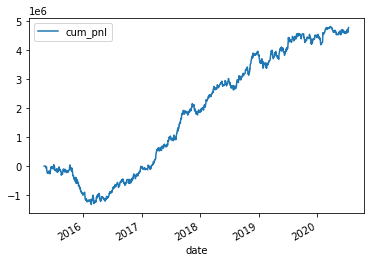

                               0
avg_pnl_1y          2.027379e+03
avg_pnl_2y          4.293104e+03
avg_pnl_3y          5.225215e+03
avg_pnl_4y          5.642924e+03
max_dd_period_1y   -1.420000e+02
max_dd_period_2y   -5.500000e+01
max_dd_period_3y   -5.500000e+01
max_dd_period_4y   -5.500000e+01
max_drawdown_1y    -3.895657e+05
max_drawdown_2y    -5.857348e+05
max_drawdown_3y    -5.857348e+05
max_drawdown_4y    -5.857348e+05
num_days_1y         2.430000e+02
num_days_2y         4.850000e+02
num_days_3y         7.300000e+02
num_days_4y         9.730000e+02
profit_dd_ratio_1y  1.264621e+00
profit_dd_ratio_2y  3.554775e+00
profit_dd_ratio_3y  6.512175e+00
profit_dd_ratio_4y  9.373808e+00
sharp_ratio_1y      7.382116e-01
sharp_ratio_2y      1.372301e+00
sharp_ratio_3y      1.723616e+00
sharp_ratio_4y      1.930283e+00
std_pnl_1y          4.359676e+04
std_pnl_2y          4.966179e+04
std_pnl_3y          4.812424e+04
std_pnl_4y          4.640699e+04
tot_cost_1y         5.191200e+05
tot_cost_2

In [48]:
total_risk = 10000000.0
rebal_freq = 3
margin_rate = [0.08, 0.08]
pnl_tenors = ['1y', '2y', '3y', '4y']
cost_ratio = 1.0
offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
offset_list = [x * 0.4 for x in offset_list]
start_capital = 0.0

quantile_cutoff = 0.20
kcut = int(quantile_cutoff * len(product_list) + 0.5)
upper_rank = len(product_list) - kcut
lower_rank = 1 + kcut
print(upper_rank, lower_rank)
xdf['rebal_flag'] = 1
#print rng_dict['lr0'][-10:]
flag = (xdf['start_min'].isin([])) | (rng_dict['lr0'] < 0.2)
xdf.loc[flag, 'rebal_flag'] = 0

xdf['rebal_seqno'] = xdf['rebal_flag'].cumsum()
#print(xdf[['rebal_seqno', 'start_min', 'rebal_flag']][-10:])

#xdf['rebal_seqno'] = range(len(xdf.index))

sum_rank = pd.DataFrame(columns=product_list, index = xdf.index)
for asset in product_list:
    sum_rank[asset] = rank_dict['lr0'][(asset, 'lr0')]
    for col in ['lr%s'%(idx+1) for idx in range(len(win_list)-1)]:
        sum_rank[asset] = sum_rank[asset] + rank_dict[col][(asset, col)]

sum_rank = sum_rank.rank(axis=1, method='first')
print(sum_rank)
long_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)
short_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)

for rebal_idx in range(rebal_freq):
    long_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
    short_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
    rebal_flag = xdf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx) & (xdf['rebal_flag'] == 1)
    for asset in product_list:
        long_tmp.loc[(sum_rank[asset] > upper_rank) & rebal_flag, asset] = 1.0
        long_tmp.loc[(sum_rank[asset] <= upper_rank) & rebal_flag, asset] = 0.0
        short_tmp.loc[(sum_rank[asset] < lower_rank) & rebal_flag, asset] = 1.0
        short_tmp.loc[(sum_rank[asset] >= lower_rank) & rebal_flag, asset] = 0.0
    long_tmp = long_tmp.fillna(method='ffill').fillna(0)
    short_tmp = short_tmp.fillna(method='ffill').fillna(0)
    #long_sum = long_tmp.sum(axis=1)
    #short_sum = short_tmp.sum(axis=1)
    long_pos = long_pos + long_tmp #.div(long_sum,axis=0)
    short_pos = short_pos + short_tmp #.div(short_sum,axis=0)

net_pos = long_pos - short_pos

pos_nchg = (net_pos == net_pos.shift(1))
net_pos[pos_nchg] = np.nan

extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
df_list = []

for asset, offset in zip(product_list, offset_list):
    #long_pos[asset] = (long_pos[asset] * total_risk/xdf[(asset,'close')].astype('float')).shift(1).fillna(method='ffill') # 
    #short_pos[asset] = (short_pos[asset] * total_risk/xdf[(asset,'close')].astype('float')).shift(1).fillna(method='ffill') # 
    net_pos[asset] = (net_pos[asset] * total_risk / (rebal_freq * xdf[(asset, 'std')])).astype('float').shift(1).fillna(method='ffill').fillna(0.0).astype('int')
    #long_pos[asset] = (long_pos[asset] * self.total_risk / xdf[(asset, 'close')].astype('float')).astype('int').shift(1).fillna(method='ffill')
    #short_pos[asset] = (short_pos[asset] * self.total_risk / xdf[(asset, 'close')].astype('float')).astype('int').shift(1).fillna(method='ffill')
    xdf[(asset, 'pos')] = net_pos[asset]
    #xdf[(asset, 'pos')] = long_pos[asset] - short_pos[asset]
    xdf[(asset, 'traded_price')] = xdf[(asset, 'open')]
    xdf[(asset, 'pos')][-1] = 0
    xdf[(asset, 'cost')] = abs(xdf[(asset, 'pos')] - xdf[(asset, 'pos')].shift(1)) * offset
    xdf[(asset, 'cost')] = xdf[(asset, 'cost')].fillna(0.0)
    fields = [(asset, field) for field in extract_fields]    
    tdf = xdf[fields]
    tdf.columns = extract_fields
    tdf['date'] = xdf['date']
    tdf['min_id'] = xdf['min_id']
    #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
    df_list.append(tdf)
    #tdf.to_csv("test_%s_offset_%s.csv" % (asset, offset))
(res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, 'm', tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
print(xdf[[(asset, 'pos') for asset in product_list]][-40:])
print(ts['cum_pnl'][-60:])
ts[['cum_pnl']].plot()
plt.show()
pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
print(pnl_df)


In [87]:
#adf = xdf[[(asset, 'pos') for asset in product_list]]
#adf = adf.resample('D').last().dropna()

filename = ''.join([asset[0] for asset in product_list]) + '_' + bar_freq + '.csv'
ts.to_csv(filename)
